# Supervised Learning

**Algorithms**:

**K-Nearest Neighbors (KNN):**
- *Pros:* Intuitive, no complex training required.
- *Cons:* Performance may degrade with large datasets, sensitive to feature scale.

**Decision Trees:**
- *Pros:* Intuitive, automatically handles relevant features.
- *Cons:* Tendency to overfit, can be unstable with small variations in data.

**Linear Regression:**
- *Pros:* Simple and interpretable, suitable for capturing linear relationships.
- *Cons:* Sensitive to outliers, may not handle complex stock price movements well.

**Logistic Regression:**
- *Pros:* Suitable for binary classification tasks.
- *Cons:* Assumes linear relationship, may struggle with capturing intricate stock price patterns.

**Support Vector Machines (SVM):**
- *Pros:* Good in high-dimensional spaces.
- *Cons:* Requires careful parameter tuning, may not be optimal for large datasets.

**Random Forest:**
- *Pros:* Effective at handling complexity, provides feature importance.
- *Cons:* Less interpretable, training can be time-consuming.

**Neural Networks:**
- *Pros:* Effective for complex, non-linear patterns.
- *Cons:* Requires substantial data and computational resources, architecture complexity.

We exclude Linear Regression, Decision Trees, Support Vector Machines (SVM), and Convolutional Neural Networks (CNN).

**Considerations**:

We can use the remaining algorithms to split the problem into three categories: Target 1 day, Target 5 days, Target 30 days. If the prediction doesn't belong to any of these categories, we classify the problem as Unsafe.

We then train the dataset to find the best algorithm with the following algorithms:
- Knn
- Logistic Regression 
- Random Forests
- Neural Networks

# Data Preparation

In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
import warnings
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import seaborn as sns
from sklearn.metrics import confusion_matrix
from xgboost import plot_importance
warnings.filterwarnings("ignore")

In [2]:
df = pd.ExcelFile('final_dataset.xlsx').parse('Sheet1')
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Daily_Return,Daily_Return_Percentage,...,MA_30,MA_50,RSI,MACD,Signal_Line,Bollinger_Mid_Band,Bollinger_Upper_Band,Bollinger_Lower_Band,Volatility,Ticker
0,2020-06-30,179.305945,183.533295,179.102439,182.802521,3102800,0.0,0.0,3.496576,1.912761,...,185.971379,177.444586,40.980241,0.824023,3.006285,190.221655,205.998882,174.444429,6.840469,GS
1,2020-07-01,183.968061,184.763579,180.859992,182.756287,2620100,0.0,0.0,-1.211774,-0.663055,...,186.614105,177.904132,52.500011,0.573091,2.519646,189.620391,205.574176,173.666606,6.521267,GS
2,2020-07-02,187.316608,187.779118,182.349254,182.598999,2699400,0.0,0.0,-4.717609,-2.583590,...,187.140969,178.320634,46.428544,0.357413,2.087199,188.814696,204.471975,173.157416,5.091692,GS
3,2020-07-06,186.243599,192.209977,186.049352,191.812225,3567700,0.0,0.0,5.568627,2.903166,...,188.016001,178.938500,50.786526,0.919320,1.853623,188.326285,202.922613,173.729956,4.048404,GS
4,2020-07-07,190.091704,190.285964,184.254827,184.412079,2853500,0.0,0.0,-5.679625,-3.079855,...,188.649571,179.372512,42.843182,0.758759,1.634651,187.334203,200.017990,174.650416,4.947823,GS


## Data Cleaning

Let's transform the following features into float-type data. This transformation is essential to ensure that the data can be processed by our training algorithms effectively. Converting these features to float allows our algorithms to handle and analyze the data appropriately during the training process. This step is crucial for the accuracy and efficiency of the machine learning models we'll be using.

In [3]:
df = df[(df['Target_1day'] != -1) & (df['Target_5days'] != -1) & (df['Target_30days'] != -1)]
df['Volume'] = df['Volume'].astype(float)
df['Target_1day'] = df['Target_1day'].astype(float)
df['Target_5days'] = df['Target_5days'].astype(float)
df['Target_30days'] = df['Target_30days'].astype(float)
df['Net Income'] = df['Net Income'].astype(float)
df['Total Revenue'] = df['Total Revenue'].astype(float)
df['Normalized EBITDA'] = df['Normalized EBITDA'].astype(float)
df['Total Unusual Items'] = df['Total Unusual Items'].astype(float)
df['Total Unusual Items Excluding Goodwill'] = df['Total Unusual Items Excluding Goodwill'].astype(float)
df['Operating Cash Flow'] = df['Operating Cash Flow'].astype(float)
df['Capital Expenditure'] = df['Capital Expenditure'].astype(float)
df['Free Cash Flow'] = df['Free Cash Flow'].astype(float)
df['Cash Flow From Continuing Operating Activities'] = df['Cash Flow From Continuing Operating Activities'].astype(float)
df['Cash Flow From Continuing Investing Activities'] = df['Cash Flow From Continuing Investing Activities'].astype(float)
df['Cash Flow From Continuing Financing Activities'] = df['Cash Flow From Continuing Financing Activities'].astype(float)

## Train, Validation, Test 

The dataset `df` is divided into features (`X`) and three different target variables (`Y_1`, `Y_2`, and `Y_3`), corresponding to predicting stock values for 1, 5, and 30 days, respectively. The data is then split into training (80%), validation (20%), and test sets (20%). This separation ensures that the machine learning models can be trained, validated, and tested on distinct subsets of the data, facilitating the evaluation of their performance on different time horizons.

In [4]:
df.sort_values(by='Date', inplace=True)
X = df.drop(['Date','Ticker','Target_1day', 'Target_5days', 'Target_30days'], axis=1)
Y_1 = df['Target_1day']
Y_2 = df['Target_5days']
Y_3 = df['Target_30days']

X_train_1_80, X_test_1, Y_train_1_80, Y_test_1 = train_test_split(X, Y_1, test_size=0.2, shuffle=False)
X_train_1, X_valid_1, Y_train_1, Y_valid_1 = train_test_split(X_train_1_80, Y_train_1_80, test_size=0.20, shuffle=False)


X_train_2_80, X_test_2, Y_train_2_80, Y_test_2 = train_test_split(X, Y_2, test_size=0.2, shuffle=False)
X_valid_2, X_train_2, Y_valid_2, Y_train_2 = train_test_split(X_train_2_80, Y_train_2_80, test_size=0.20, shuffle=False)

X_train_3_80, X_test_3, Y_train_3_80, Y_test_3 = train_test_split(X, Y_3, test_size=0.2, shuffle=False)
X_valid_3, X_train_3, Y_valid_3, Y_train_3 = train_test_split(X_train_3_80, Y_train_3_80, test_size=0.20, shuffle=False)

In the subsequent section of the document, we will be conducting testing on the selected machine learning algorithms to assess their performance in predicting stock values. The focus will be on evaluating the algorithms based on accuracy to determine which one is most effective for solving this specific problem. This testing phase aims to provide insights into the algorithm that yields the most accurate predictions for the given dataset and target variables.

# Knn

In this section, we explore the K-Nearest Neighbors (KNN) algorithm by varying the parameter K, which represents the number of neighbors considered for classification. The objective is to identify the optimal K value that produces the most accurate predictions for our specific stock value prediction problem. By systematically testing different K values, we aim to determine the configuration that yields the highest accuracy, providing valuable insights into the performance of the KNN algorithm in this context.

In [5]:
best_k = []
for i in [5,10,15,20,25,30,35,40,45,50]:
    print('K: ' + str(i) + '\n')
    # Target 1 day
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_1, Y_train_1)
    train_acc_1 = accuracy_score(y_true= Y_train_1, y_pred= knn.predict(X_train_1))
    valid_acc_1 = accuracy_score(y_true= Y_valid_1, y_pred= knn.predict(X_valid_1))
    print("Train set 1: {:.2f}".format(train_acc_1))
    print('Validation set 1: {:.2f}'.format(valid_acc_1))
    # Target 5 days
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_2, Y_train_2)
    train_acc_2 = accuracy_score(y_true= Y_train_2, y_pred= knn.predict(X_train_2))
    valid_acc_2 = accuracy_score(y_true= Y_valid_2, y_pred= knn.predict(X_valid_2))
    print("Train set 2: {:.2f}".format(train_acc_2))
    print('Validation set 2: {:.2f}'.format(valid_acc_2))
    # Target 30 days
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_3, Y_train_3)
    train_acc_3 = accuracy_score(y_true= Y_train_3, y_pred= knn.predict(X_train_3))
    valid_acc_3 = accuracy_score(y_true= Y_valid_3, y_pred= knn.predict(X_valid_3))
    print("Train set 3: {:.2f}".format(train_acc_3))
    print('Validation set 3: {:.2f}'.format(valid_acc_3))
    print('\n')
    best_k.append([i, (valid_acc_1 + valid_acc_2 + valid_acc_3) / 3, (train_acc_1 + train_acc_2 + train_acc_3) / 3])
    
k = max(best_k, key=lambda x:x[1])[0]
print('Best K: ' + str(k) + '\n')
# Target 1 day
knn_1 = KNeighborsClassifier(n_neighbors=k)
knn_1.fit(X_train_1_80, Y_train_1_80)
test_acc_1 = accuracy_score(y_true= Y_test_1, y_pred= knn_1.predict(X_test_1))
print('Test set 1: {:.2f}'.format(test_acc_1))

# Target 5 days
knn_2 = KNeighborsClassifier(n_neighbors=k)
knn_2.fit(X_train_2_80, Y_train_2_80)
test_acc_2 = accuracy_score(y_true= Y_test_2, y_pred= knn_2.predict(X_test_2))
print('Test set 2: {:.2f}'.format(test_acc_2))

# Target 30 days
knn_3 = KNeighborsClassifier(n_neighbors=k)
knn_3.fit(X_train_3_80, Y_train_3_80)
test_acc_3 = accuracy_score(y_true= Y_test_3, y_pred= knn_3.predict(X_test_3))
print('Test set 3: {:.2f}'.format(test_acc_3))

# Total acc
print('Total acc: {:.2f}'.format((test_acc_1 + test_acc_2 + test_acc_3) / 3))

K: 5
Train set 1: 0.71
Validation set 1: 0.51
Train set 2: 0.72
Validation set 2: 0.50
Train set 3: 0.74
Validation set 3: 0.51


K: 10
Train set 1: 0.64
Validation set 1: 0.50
Train set 2: 0.64
Validation set 2: 0.49
Train set 3: 0.70
Validation set 3: 0.50


K: 15
Train set 1: 0.61
Validation set 1: 0.50
Train set 2: 0.62
Validation set 2: 0.49
Train set 3: 0.68
Validation set 3: 0.51


K: 20
Train set 1: 0.59
Validation set 1: 0.50
Train set 2: 0.61
Validation set 2: 0.49
Train set 3: 0.67
Validation set 3: 0.50


K: 25
Train set 1: 0.59
Validation set 1: 0.49
Train set 2: 0.61
Validation set 2: 0.49
Train set 3: 0.67
Validation set 3: 0.51


K: 30
Train set 1: 0.58
Validation set 1: 0.49
Train set 2: 0.60
Validation set 2: 0.50
Train set 3: 0.67
Validation set 3: 0.50


K: 35
Train set 1: 0.58
Validation set 1: 0.50
Train set 2: 0.60
Validation set 2: 0.50
Train set 3: 0.66
Validation set 3: 0.50


K: 40
Train set 1: 0.57
Validation set 1: 0.51
Train set 2: 0.59
Validation set 2: 0

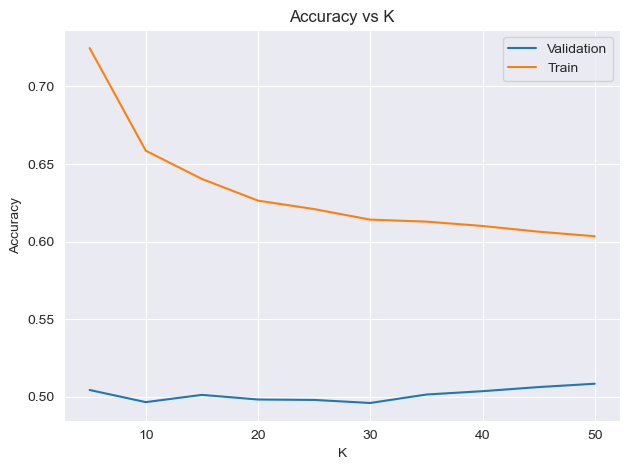

In [6]:
k_values = [item[0] for item in best_k]
validation_accuracy_values = [item[1] for item in best_k]
train_accuracy_values = [item[2] for item in best_k]

plt.plot(k_values, validation_accuracy_values, label='Validation')
plt.plot(k_values, train_accuracy_values, label='Train')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('Accuracy vs K')
plt.legend()


plt.tight_layout()
plt.show()

There are some important considerations to take into account:

1. **Small \(k\):** A small \(k\) value implies that the prediction for a data point is heavily influenced by its immediate neighbors. This makes the model sensitive to local variations in the training data, which might not generalize well to unseen data.

2. **Total Accuracy:** The total accuracy across all targets is reported around 50%, which is the average of the accuracies for the three target variables. This value suggests that the model is performing slightly better than random chance.

3. **Generalization Concerns:** While the model might perform quite well on the training sets, the real test lies in its ability to generalize to unseen data. The model's performance on the test sets should be carefully examined to assess its effectiveness in predicting stock values for different time horizons.

# Logistic Regression

In this section, we explore the training process of Logistic Regression for the stock prediction problem, aiming to analyze its outcomes. Logistic Regression is a well-established algorithm for binary classification tasks, making it suitable for predicting whether stock values will rise or fall.

First of all we scale the data to improve the performance of the algorithm:

In [7]:
scaler = StandardScaler()

# Target 1 day
X_train_1_80_scaled = scaler.fit_transform(X_train_1_80)
X_valid_1_scaled = scaler.transform(X_valid_1)
X_test_1_scaled = scaler.transform(X_test_1)
X_train_1_scaled = scaler.transform(X_train_1)

# Target 5 days
X_train_2_80_scaled = scaler.fit_transform(X_train_2_80)
X_valid_2_scaled = scaler.transform(X_valid_2)
X_test_2_scaled = scaler.transform(X_test_2)
X_train_2_scaled = scaler.transform(X_train_2)

# Target 30 days
X_train_3_80_scaled = scaler.fit_transform(X_train_3_80)
X_valid_3_scaled = scaler.transform(X_valid_3)
X_test_3_scaled = scaler.transform(X_test_3)
X_train_3_scaled = scaler.transform(X_train_3)

In [8]:
# Define datasets
datasets = [(X_train_1_scaled, Y_train_1, X_valid_1_scaled, Y_valid_1, X_test_1_scaled, Y_test_1),
            (X_train_2_scaled, Y_train_2, X_valid_2_scaled, Y_valid_2, X_test_2_scaled, Y_test_2),
            (X_train_3_scaled, Y_train_3, X_valid_3_scaled, Y_valid_3, X_test_3_scaled, Y_test_3)]

sum = 0

# Loop through datasets
for i, (X_train, Y_train, X_valid, Y_valid, X_test, Y_test) in enumerate(datasets):

    # Train
    lr = LogisticRegression(max_iter=1000)
    lr.fit(X_train, Y_train)
    train_acc = accuracy_score(y_true=Y_train, y_pred=lr.predict(X_train))
    valid_acc = accuracy_score(y_true=Y_valid, y_pred=lr.predict(X_valid))

    # Test
    lr_test = LogisticRegression(max_iter=1000)
    lr_test.fit(X_train, Y_train)
    test_acc = accuracy_score(y_true=Y_test, y_pred=lr_test.predict(X_test))
    print(f'Target {i + 1} - Train Accuracy: {train_acc:.2f} - Validation Accuracy: {valid_acc:.2f} - Test Accuracy: {test_acc:.2f}')
    sum += test_acc
    
# Total acc
print(f'Total acc: {sum / 3:.2f}')

Target 1 - Train Accuracy: 0.52 - Validation Accuracy: 0.49 - Test Accuracy: 0.52
Target 2 - Train Accuracy: 0.57 - Validation Accuracy: 0.49 - Test Accuracy: 0.52
Target 3 - Train Accuracy: 0.65 - Validation Accuracy: 0.52 - Test Accuracy: 0.50
Total acc: 0.51


The accuracy levels are relatively close for the different target periods, indicating a consistent but not particularly strong predictive performance across various prediction horizons. The model's accuracy on the training and validation sets is also similar, suggesting that the model is not overfitting to the training data. However, the accuracy levels are relatively low, indicating that the model may not be capturing the underlying patterns in the data effectively.
We should also consider that the dataset could be imbalanced, which could affect the model's performance. To address this issue, we will explore the impact of oversampling the minority class on the model's accuracy. 

In [9]:
from imblearn.over_sampling import SMOTE

# Define datasets
datasets = [(X_train_1_scaled, Y_train_1, X_valid_1_scaled, Y_valid_1, X_test_1_scaled, Y_test_1),
            (X_train_2_scaled, Y_train_2, X_valid_2_scaled, Y_valid_2, X_test_2_scaled, Y_test_2),
            (X_train_3_scaled, Y_train_3, X_valid_3_scaled, Y_valid_3, X_test_3_scaled, Y_test_3)]

sum = 0

# Loop through datasets
for i, (X_train, Y_train, X_valid, Y_valid, X_test, Y_test) in enumerate(datasets):

    # Oversample
    oversample = SMOTE()
    X_train, Y_train = oversample.fit_resample(X_train, Y_train)

    # Train
    lr = LogisticRegression(max_iter=1000)
    lr.fit(X_train, Y_train)
    train_acc = accuracy_score(y_true=Y_train, y_pred=lr.predict(X_train))
    valid_acc = accuracy_score(y_true=Y_valid, y_pred=lr.predict(X_valid))

    # Test
    lr_test = LogisticRegression(max_iter=1000)
    lr_test.fit(X_train, Y_train)
    test_acc = accuracy_score(y_true=Y_test, y_pred=lr_test.predict(X_test))
    print(f'Target {i + 1} - Train Accuracy: {train_acc:.2f} - Validation Accuracy: {valid_acc:.2f} - Test Accuracy: {test_acc:.2f}')
    sum += test_acc
    
# Total acc
print(f'Total acc: {sum / 3:.2f}')

Target 1 - Train Accuracy: 0.53 - Validation Accuracy: 0.49 - Test Accuracy: 0.52
Target 2 - Train Accuracy: 0.57 - Validation Accuracy: 0.49 - Test Accuracy: 0.51
Target 3 - Train Accuracy: 0.65 - Validation Accuracy: 0.52 - Test Accuracy: 0.50
Total acc: 0.51


The results of the oversampling experiment reveal that the model's accuracy levels remain relatively consistent across different target periods. However, the accuracy levels are still relatively low, indicating that the model may not be capturing the underlying patterns in the data effectively. Further analysis and potentially more sophisticated models might be explored to enhance predictive performance.

# Artificial Neural Networks

In this phase of our analysis, we turn our attention to the Artificial Neural Networks (ANN) algorithm. To explore its behavior and identify the optimal configuration for our problem, we experiment with different random states and maximum iterations.

The choice of random state can influence the initialization of the neural network weights, affecting its convergence to the optimal solution. By trying various random states, we aim to discern patterns in the model's performance and evaluate its robustness to different initializations.

Additionally, adjusting the maximum number of iterations allows us to explore how well the ANN converges within a given timeframe. This is particularly crucial for complex problems where finding the optimal parameters may require more or fewer iterations.

By systematically varying these parameters and assessing their impact on accuracy, we aim to determine the most effective setup for our ANN in predicting stock values over different time horizons.

In [11]:
# Initialize lists to store histories
histories = []

for target, X_train_80, X_train, X_valid, X_test, Y_train_80, Y_train, Y_valid, Y_test in [
    (1, X_train_1_80, X_train_1, X_valid_1, X_test_1, Y_train_1_80, Y_train_1, Y_valid_1, Y_test_1),
    (2, X_train_2_80, X_train_2, X_valid_2, X_test_2, Y_train_2_80, Y_train_2, Y_valid_2, Y_test_2),
    (3, X_train_3_80, X_train_3, X_valid_3, X_test_3, Y_train_3_80, Y_train_3, Y_valid_3, Y_test_3)
]:
    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)
    X_test_scaled = scaler.transform(X_test)
    
    # Initialize parameters
    best_acc = 0
    best_epoch = 0
    best_node = 0
    best_layer = 0 

    # Initialize history dictionary
    history_dict = {'accuracy': [], 'validation_accuracy': [], 'test_accuracy': [], 'loss': [], 'validation_loss': [], 'test_loss': []}
    
    # Tuning parameters
    for nodes in [8, 16, 24]:
        for n_layers in [1, 2, 3]:
            for epochs in [30, 50, 100]:
                

                model = models.Sequential()
                model.add(layers.Dense(nodes, activation='sigmoid', input_shape=(X_train_scaled.shape[1],)))
                for _ in range(n_layers):
                    model.add(layers.Dense(nodes, activation='sigmoid'))
                model.add(layers.Dense(1, activation='sigmoid'))
                model.compile(optimizer=optimizers.legacy.Adam(learning_rate=0.01),
                              loss='binary_crossentropy',
                              metrics=['accuracy'])
                
                early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

                history = model.fit(X_train_scaled, Y_train, epochs=epochs, validation_data=(X_valid_scaled, Y_valid), callbacks=[early_stopping], verbose=0)

                # Store history information
                history_dict['accuracy'].extend(history.history['accuracy'])
                history_dict['validation_accuracy'].extend(history.history.get('val_accuracy', []))  # Use get to handle missing key
                test_eval = model.evaluate(X_test_scaled, Y_test, verbose=0)
                history_dict['test_accuracy'].append(test_eval[1])  # Evaluate on test set
                history_dict['loss'].extend(history.history['loss'])
                history_dict['validation_loss'].extend(history.history.get('val_loss', []))  # Use get to handle missing key
                history_dict['test_loss'].append(test_eval[0])  # Evaluate on test set

                if test_eval[1] > best_acc:
                    best_acc = test_eval[1]
                    best_epoch = epochs
                    best_node = nodes
                    best_layer = n_layers

    histories.append((target, history_dict, best_epoch, best_node, best_layer, best_acc))

    print(f'Target {target} - Best Epochs: {best_epoch}, Best Nodes: {best_node}, Best Layers: {best_layer}, Best Accuracy: {best_acc:.2f}')

Target 1 - Best Epochs: 30, Best Nodes: 24, Best Layers: 3, Best Accuracy: 0.52
Target 2 - Best Epochs: 100, Best Nodes: 16, Best Layers: 1, Best Accuracy: 0.52
Target 3 - Best Epochs: 50, Best Nodes: 8, Best Layers: 3, Best Accuracy: 0.52


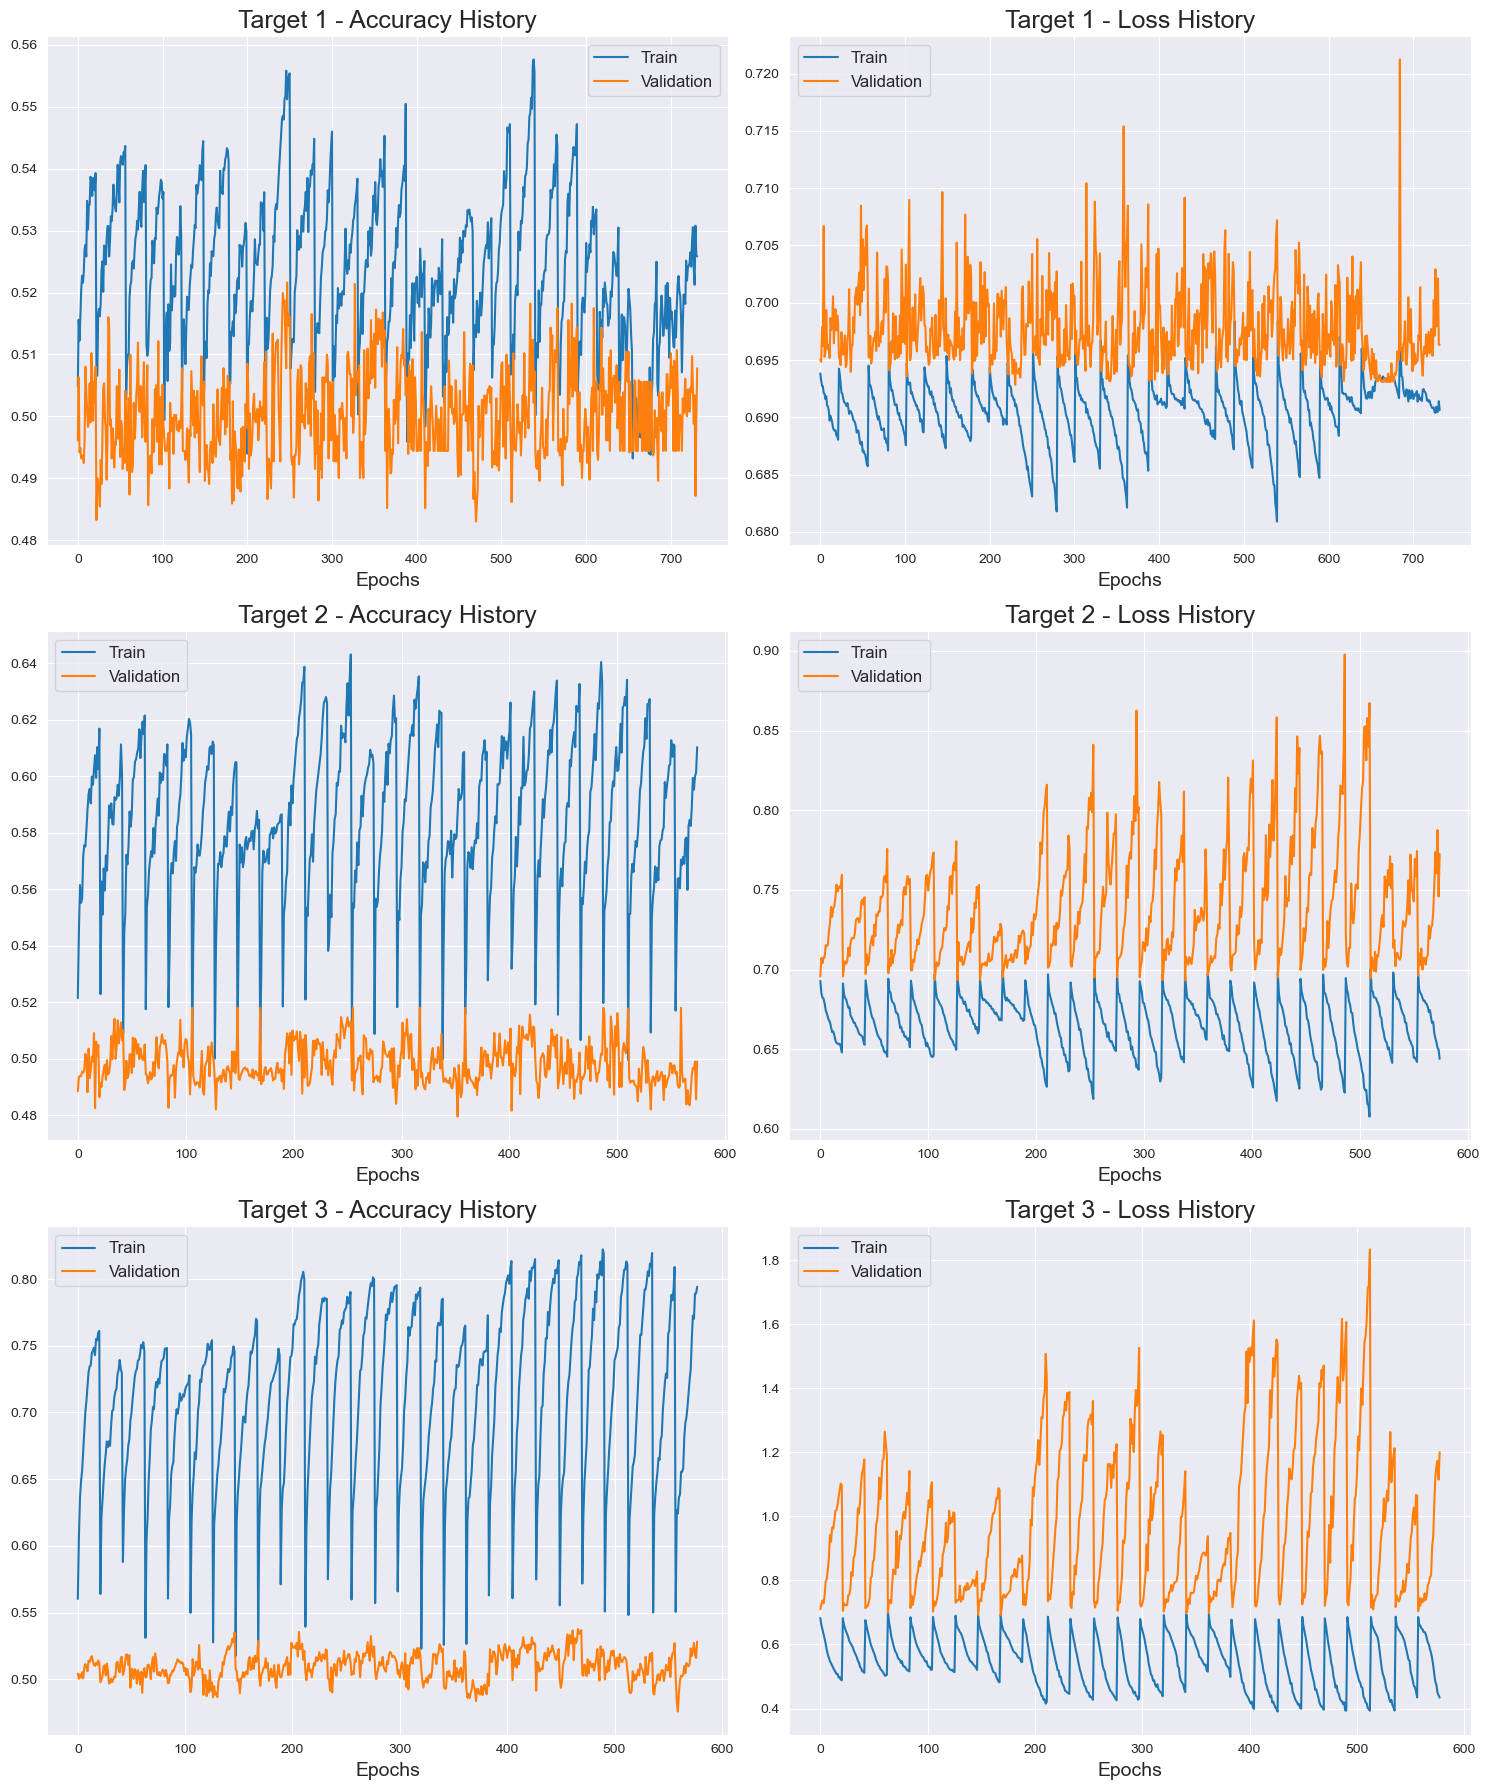

In [13]:
# Plotting
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 18))

for i, (target, history_dict, best_epoch, best_node, best_layer, best_acc) in enumerate(histories):
    row = i
    col_acc = 0
    col_loss = 1

    axes[row, col_acc].plot(history_dict['accuracy'], label='Train')
    axes[row, col_acc].plot(history_dict['validation_accuracy'], label='Validation')
    #axes[row, col_acc].plot(history_dict['test_accuracy'], label='Test')
    axes[row, col_acc].set_title(f"Target {target} - Accuracy History", fontsize=18)
    axes[row, col_acc].set_xlabel("Epochs", fontsize=14)
    axes[row, col_acc].legend(fontsize=12)

    axes[row, col_loss].plot(history_dict['loss'], label='Train')
    axes[row, col_loss].plot(history_dict['validation_loss'], label='Validation')
    #axes[row, col_loss].plot(history_dict['test_loss'], label='Test')
    axes[row, col_loss].set_title(f"Target {target} - Loss History", fontsize=18)
    axes[row, col_loss].set_xlabel("Epochs", fontsize=14)
    axes[row, col_loss].legend(fontsize=12)

plt.tight_layout()
plt.show()

The accuracy and loss graphs reveal that there is overfitting the model is too complex for the given problem. The model's accuracy and loss continue to go up and down, indicating that the model is not converging to the optimal solution. This suggests that the model is not learning the underlying patterns in the data effectively, resulting in poor predictive performance.

In [14]:
datas = []

for target, X_train_80, X_train, X_valid, X_test, Y_train_80, Y_train, Y_valid, Y_test in [
    (1, X_train_1_80, X_train_1, X_valid_1, X_test_1, Y_train_1_80, Y_train_1, Y_valid_1, Y_test_1),
    (2, X_train_2_80, X_train_2, X_valid_2, X_test_2, Y_train_2_80, Y_train_2, Y_valid_2, Y_test_2),
    (3, X_train_3_80, X_train_3, X_valid_3, X_test_3, Y_train_3_80, Y_train_3, Y_valid_3, Y_test_3)
]:
    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)
    X_test_scaled = scaler.transform(X_test)
    
    nodes = histories[target-1][3]
    n_layers = histories[target-1][4]
    epochs = histories[target-1][2]
    
    # Tuning parameters
    model = models.Sequential()
    model.add(layers.Dense(nodes, activation='sigmoid', input_shape=(X_train_scaled.shape[1],)))
    for _ in range(n_layers):
        model.add(layers.Dense(nodes, activation='sigmoid'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizers.legacy.Adam(learning_rate=0.01),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=epochs, restore_best_weights=True)

    history = model.fit(X_train_scaled, Y_train, epochs=epochs, validation_data=(X_valid_scaled, Y_valid), callbacks=[early_stopping], verbose=0)

    # Store history information
    train_acc = history.history['accuracy']
    val_acc = history.history.get('val_accuracy', [])  # Use get to handle missing key
    test_eval = model.evaluate(X_test_scaled, Y_test, verbose=0)
    test_acc = test_eval[1] # Evaluate on test set
    train_loss = history.history['loss']
    val_loss = history.history.get('val_loss', [])  # Use get to handle missing key
    test_loss = test_eval[0]  # Evaluate on test set
    
    datas.append((target, train_acc, val_acc, test_acc, train_loss, val_loss, test_loss))

    print(f'Target {target} - Train Accuracy: {np.mean(train_acc):.2f} - Validation Accuracy: {np.mean(val_acc):.2f} - Test Accuracy: {np.mean(test_acc):.2f}')

Target 1 - Train Accuracy: 0.52 - Validation Accuracy: 0.50 - Test Accuracy: 0.50
Target 2 - Train Accuracy: 0.67 - Validation Accuracy: 0.50 - Test Accuracy: 0.51
Target 3 - Train Accuracy: 0.74 - Validation Accuracy: 0.51 - Test Accuracy: 0.50


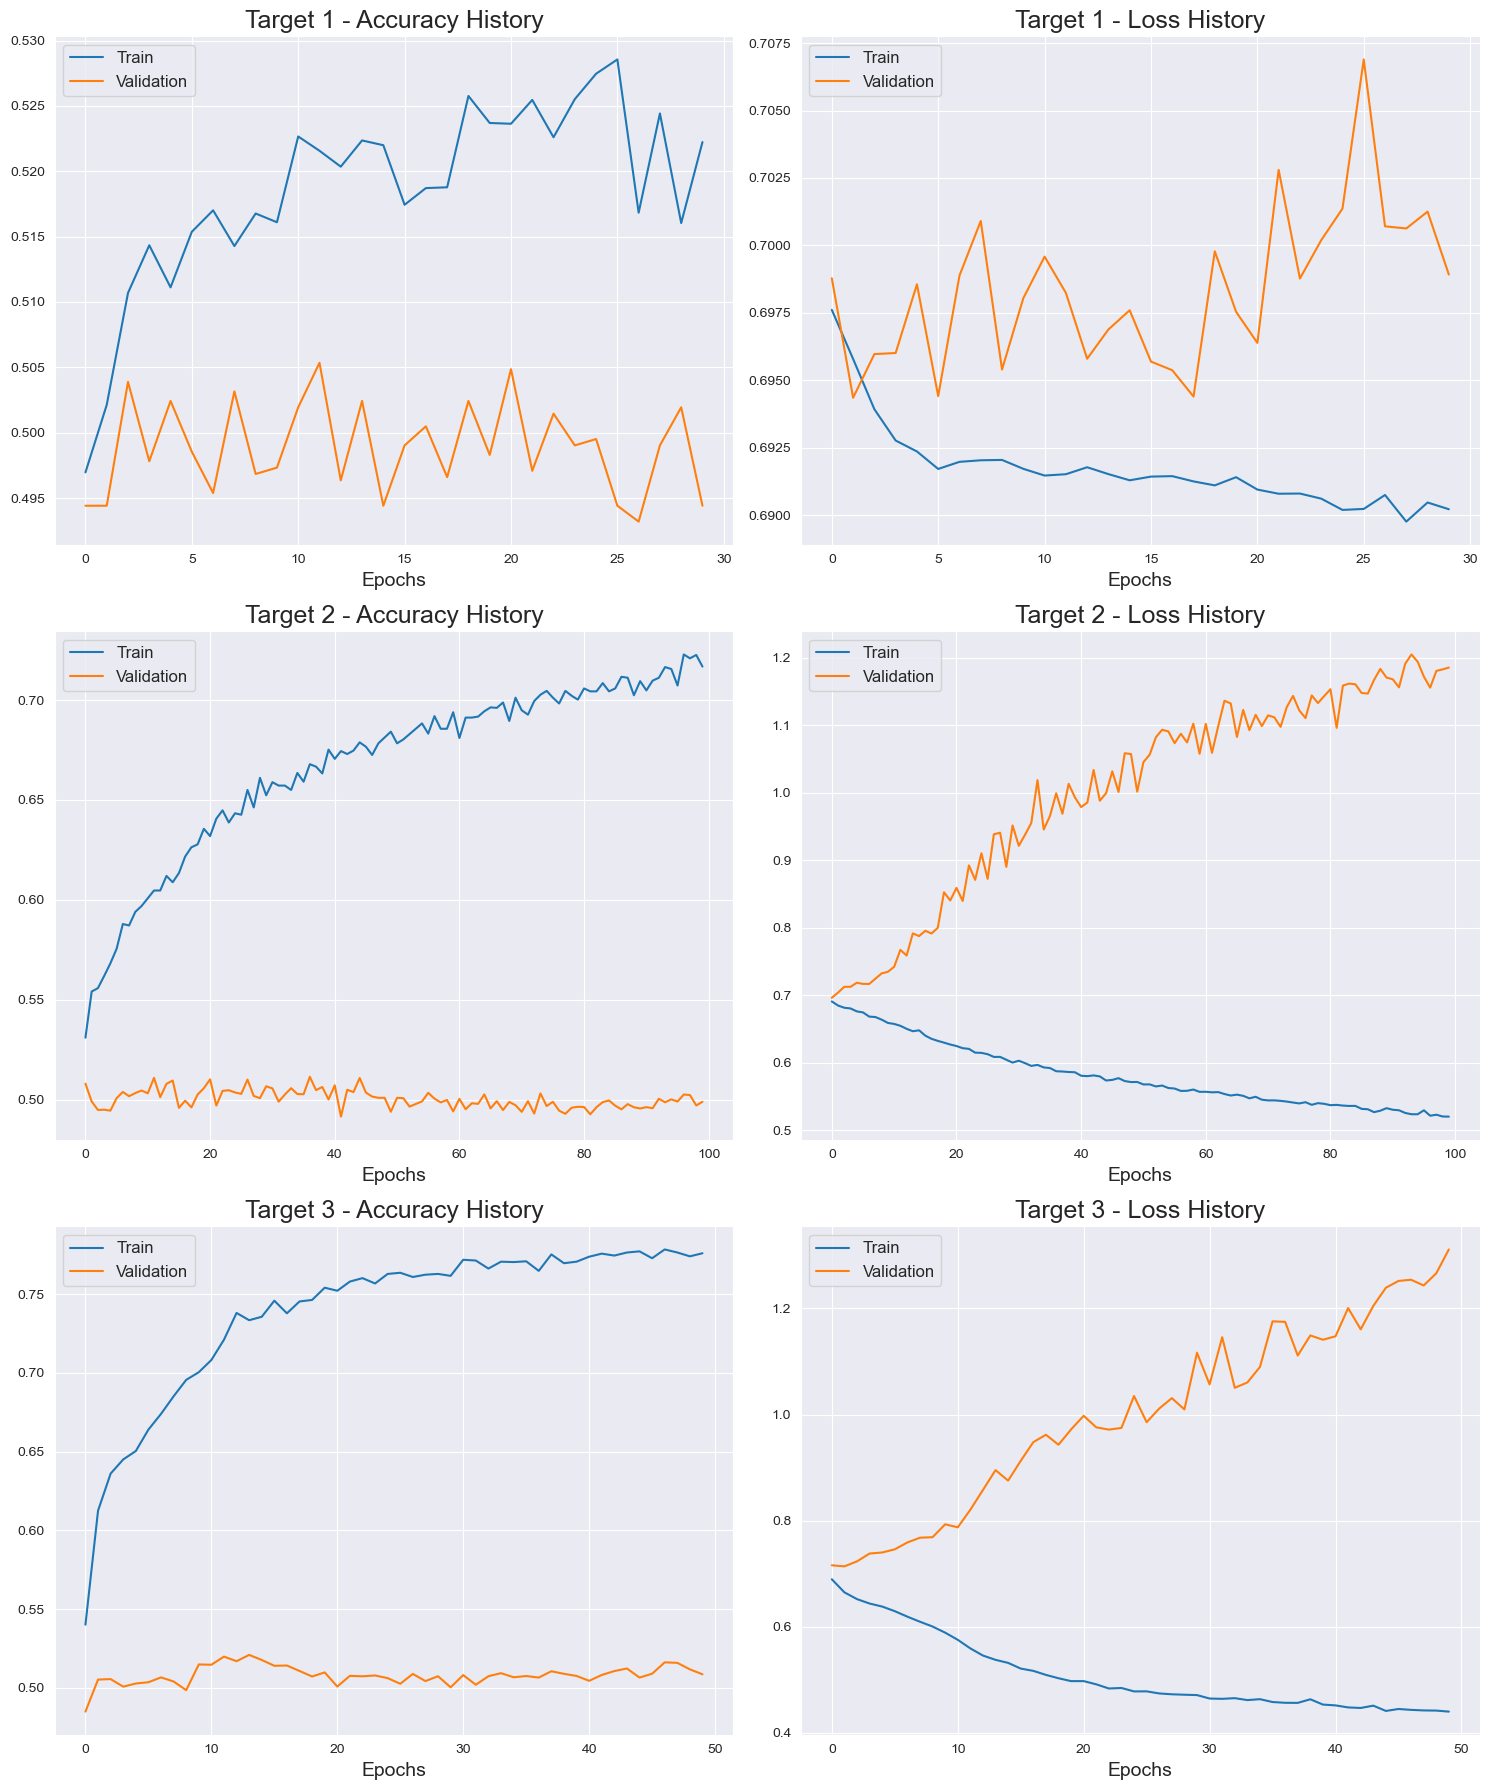

In [15]:
# Plotting
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 18))

for i, (target, train_acc, val_acc, test_acc, train_loss, val_loss, test_loss) in enumerate(datas):
    row = i
    col_acc = 0
    col_loss = 1
    
    axes[row, col_acc].plot(train_acc, label='Train')
    axes[row, col_acc].plot(val_acc, label='Validation')
    axes[row, col_acc].set_title(f"Target {target} - Accuracy History", fontsize=18)
    axes[row, col_acc].set_xlabel("Epochs", fontsize=14)
    axes[row, col_acc].legend(fontsize=12)
    
    axes[row, col_loss].plot(train_loss, label='Train')
    axes[row, col_loss].plot(val_loss, label='Validation')
    axes[row, col_loss].set_title(f"Target {target} - Loss History", fontsize=18)
    axes[row, col_loss].set_xlabel("Epochs", fontsize=14)
    axes[row, col_loss].legend(fontsize=12)

plt.tight_layout()
plt.show()

The results of the Artificial Neural Networks (ANN) experimentation reveal that, despite fine-tuning parameters such as the maximum number of iterations and random state, the model's accuracy remains relatively consistent across different configurations. The model's accuracy on the training and validation sets is also similar, suggesting that the model is not overfitting to the training data. However, the accuracy levels are relatively low, indicating that the model may not be capturing the underlying patterns in the data effectively.

# Random Forest

In this section, we aim to assess the performance of the Random Forest algorithm by experimenting with different values for the `max_depth` hyperparameter. By varying the maximum depth of the trees within the ensemble, we can observe how this impacts the model's predictive accuracy.

We will evaluate the Random Forest's performance across three target periods (1 day, 5 days, and 30 days) and assess how changes in `max_depth` influence predictive accuracy. This analysis will provide insights into the trade-off between model complexity and generalization, helping us identify an optimal depth for the trees within the ensemble.

In [16]:
best_params = []
sum = 0
for max_depth in [10, 30, 50]:
    print(f'Max Depth: {max_depth}')
    for n_estimators in [10, 25, 50]:
        print(f'N Estimators: {n_estimators}')
        for min_samples_leaf in [2,5,10]:
            print(f'Min Samples Leaf: {min_samples_leaf}')
            # Target 1 day
            rf = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators, min_samples_leaf=min_samples_leaf)
            rf.fit(X_train_1, Y_train_1)
            train_acc = accuracy_score(y_true=Y_train_1, y_pred=rf.predict(X_train_1))
            scores = cross_val_score(rf, X_train_1_80, Y_train_1_80, cv=5, scoring='accuracy', verbose=0)
            print(f"Train set 1: {train_acc:.2f}")
            print(f'Validation set 1: {scores.mean():.2f}')
            sum = scores.mean()
            # Target 5 days
            rf = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators, min_samples_leaf=min_samples_leaf)
            rf.fit(X_train_2, Y_train_2)
            train_acc = accuracy_score(y_true=Y_train_2, y_pred=rf.predict(X_train_2))
            scores = cross_val_score(rf, X_train_2_80, Y_train_2_80, cv=5, scoring='accuracy', verbose=0)
            print(f"Train set 2: {train_acc:.2f}")
            print(f'Validation set 2: {scores.mean():.2f}')
            sum += scores.mean()
            # Target 30 days
            rf = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators, min_samples_leaf=min_samples_leaf)
            rf.fit(X_train_3, Y_train_3)
            train_acc = accuracy_score(y_true=Y_train_3, y_pred=rf.predict(X_train_3))
            scores = cross_val_score(rf, X_train_3_80, Y_train_3_80, cv=5, scoring='accuracy', verbose=0)
            print(f"Train set 3: {train_acc:.2f}")
            print(f'Validation set 3: {scores.mean():.2f}\n')
            sum += scores.mean()
            best_params.append({
                'max_depth': max_depth,
                'n_estimators': n_estimators,
                'min_samples_leaf': min_samples_leaf,
                'average_accuracy': sum / 3
            })
            sum = 0

# Find the best parameters
best_param_set = max(best_params, key=lambda x: x['average_accuracy'])
print(f'Best Parameters: {best_param_set}')

Max Depth: 10
N Estimators: 10
Min Samples Leaf: 2
Train set 1: 0.67
Validation set 1: 0.50
Train set 2: 0.86
Validation set 2: 0.49
Train set 3: 0.97
Validation set 3: 0.53

Min Samples Leaf: 5
Train set 1: 0.68
Validation set 1: 0.50
Train set 2: 0.85
Validation set 2: 0.49
Train set 3: 0.93
Validation set 3: 0.54

Min Samples Leaf: 10
Train set 1: 0.66
Validation set 1: 0.50
Train set 2: 0.81
Validation set 2: 0.49
Train set 3: 0.93
Validation set 3: 0.53

N Estimators: 25
Min Samples Leaf: 2
Train set 1: 0.73
Validation set 1: 0.50
Train set 2: 0.90
Validation set 2: 0.49
Train set 3: 0.98
Validation set 3: 0.53

Min Samples Leaf: 5
Train set 1: 0.71
Validation set 1: 0.50
Train set 2: 0.88
Validation set 2: 0.49
Train set 3: 0.96
Validation set 3: 0.54

Min Samples Leaf: 10
Train set 1: 0.70
Validation set 1: 0.50
Train set 2: 0.85
Validation set 2: 0.49
Train set 3: 0.93
Validation set 3: 0.54

N Estimators: 50
Min Samples Leaf: 2
Train set 1: 0.76
Validation set 1: 0.50
Train se

In [17]:
i = best_param_set['max_depth']
j = best_param_set['n_estimators']
k = best_param_set['min_samples_leaf']
print('Best max depth: ' + str(i))
print('Best n estimators: ' + str(j))
print('Best min samples leaf: ' + str(k))
# Target 1 day
rm_1 = RandomForestClassifier(max_depth=i, n_estimators=j, min_samples_leaf=k)
rm_1.fit(X_train_1_80, Y_train_1_80)
test_acc_1 = accuracy_score(y_true= Y_test_1, y_pred= rm_1.predict(X_test_1))
print('Test set 1: {:.2f}'.format(test_acc_1))

# Target 5 days
rm_2 = RandomForestClassifier(max_depth=i, n_estimators=j, min_samples_leaf=k)
rm_2.fit(X_train_2_80, Y_train_2_80)
test_acc_2 = accuracy_score(y_true= Y_test_2, y_pred= rm_2.predict(X_test_2))
print('Test set 2: {:.2f}'.format(test_acc_2))

# Target 30 days
rm_3 = RandomForestClassifier(max_depth=i, n_estimators=j, min_samples_leaf=k)
rm_3.fit(X_train_3_80, Y_train_3_80)
test_acc_3 = accuracy_score(y_true= Y_test_3, y_pred= rm_3.predict(X_test_3))
print('Test set 3: {:.2f}'.format(test_acc_3))

# Total acc
print('Total acc: {:.2f}'.format((test_acc_1 + test_acc_2 + test_acc_3) / 3))

Best max depth: 10
Best n estimators: 50
Best min samples leaf: 10
Test set 1: 0.51
Test set 2: 0.51
Test set 3: 0.53
Total acc: 0.51


We have identified the optimal `max_depth`,`n_estimators` and `min_samples_leaf`  parameter for the Random Forest algorithm as `i,j,k`, we now aim to delve deeper into the feature importance of our dataset. This analysis seeks to uncover which features significantly contribute to the predictive performance of the model.

The Random Forest algorithm provides a feature importance score for each input feature, indicating its contribution to the overall predictive accuracy. By understanding the importance of each feature, we can identify key variables that play a crucial role in predicting stock values over different time horizons (1 day, 5 days, and 30 days).

This investigation into feature importance will enhance our understanding of the underlying factors driving the model's predictions and help us identify any redundant or less relevant features that may be excluded from future iterations of the model.

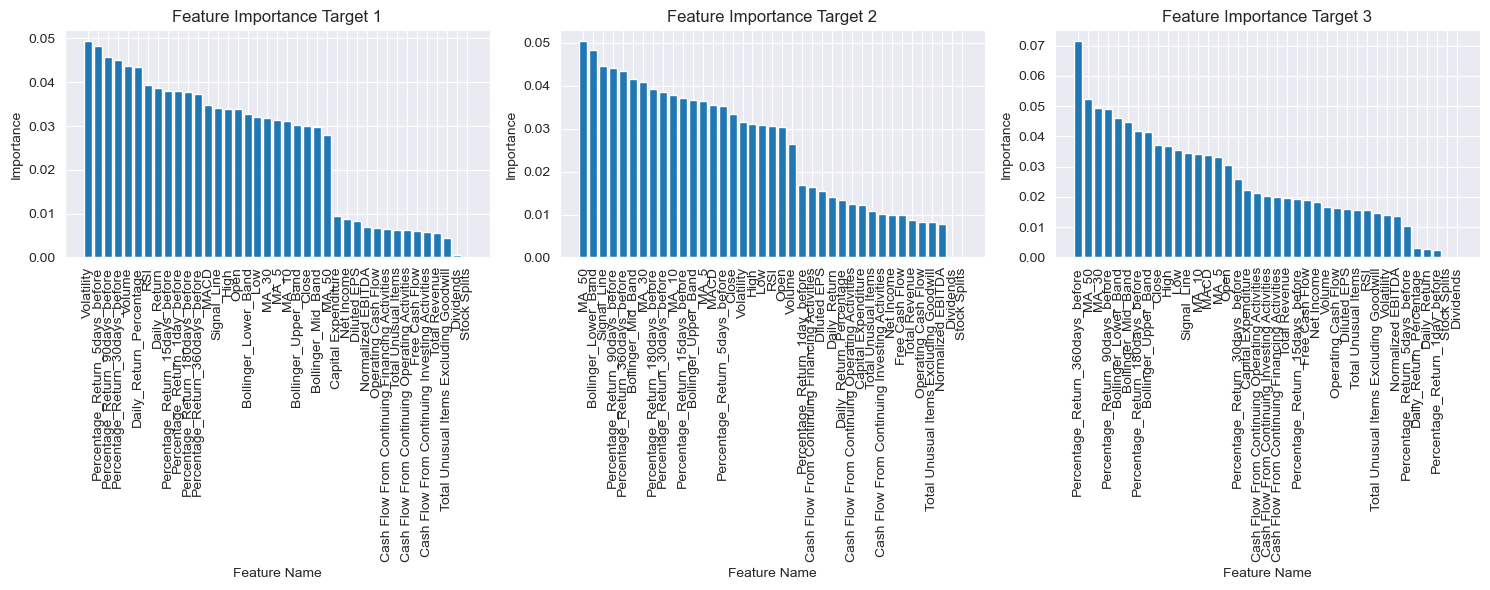

In [18]:
# Define the RandomForestClassifiers for each target
rf_models = [rm_1, rm_2, rm_3]
X_train_sets = [X_train_1_80, X_train_2_80, X_train_3_80]

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

# Iterate through targets
for target, rf_model, X_train_set, ax in zip(range(1, 4), rf_models, X_train_sets, axes):
    importances = rf_model.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Calculate the cumulative importance
    cumulative_importance = np.cumsum(importances)

    # Plotting
    ax.bar(range(X_train_set.shape[1]), importances[indices], align="center")
    ax.set_xticks(range(X_train_set.shape[1]))
    ax.set_xticklabels(X_train_set.columns[indices], rotation=90)
    ax.set_title(f"Feature Importance Target {target}")
    ax.set_xlabel("Feature Name")
    ax.set_ylabel("Importance")

plt.tight_layout()
plt.show()

After scrutinizing the dataset, we decide to exculde from th dataset all the less important features that comes after the 90% of cumulative importance. This is done to reduce the noise in the dataset and to improve the performance of the model.

Also we use a boosting algorithm to improve the performance of the model. We use the XGBoost algorithm, which is a boosting algorithm that creates a strong classifier from a number of weak classifiers. It is a fast and efficient algorithm that has been used to win many data science competitions. It is an implementation of gradient boosted decision trees designed for speed and performance.

The objective is to assess whether excluding these specific features leads to an improvement in the predictive performance of our algorithms, providing us with a more refined and accurate model for forecasting stock values over different time horizons.

Train set 1: 0.60
Validation set 1: 0.51
Test set 1: 0.51
Train set 2: 0.64
Validation set 2: 0.50
Test set 2: 0.54
Train set 3: 0.74
Validation set 3: 0.54
Test set 3: 0.50


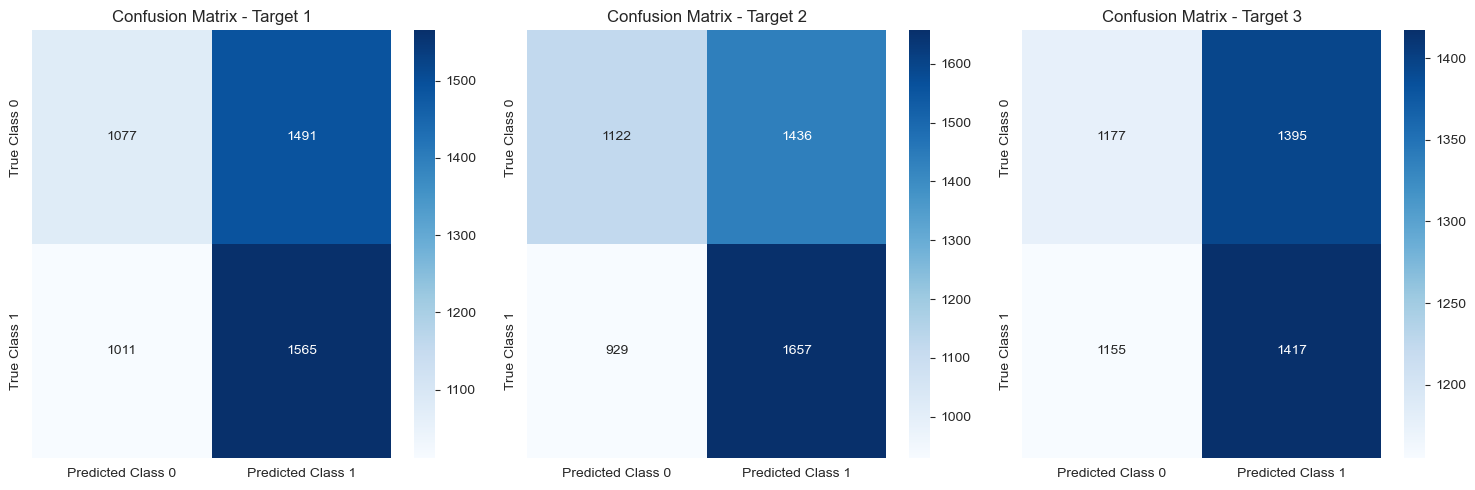

In [19]:
# Function to select features based on cumulative importance
def select_features(importances, threshold=0.9):
    sorted_indices = importances.argsort()[::-1]
    cumulative_importance = 0
    selected_features = []

    for index in sorted_indices:
        cumulative_importance += importances[index]
        selected_features.append(index)
        if cumulative_importance >= threshold:
            break

    return selected_features

feature_importances_1 = rm_1.feature_importances_
feature_importances_2 = rm_2.feature_importances_
feature_importances_3 = rm_3.feature_importances_

# Select features for each model
selected_features_1 = select_features(feature_importances_1)
selected_features_2 = select_features(feature_importances_2)
selected_features_3 = select_features(feature_importances_3)

# Create new datasets with selected features
new_x_1 = X.iloc[:, selected_features_1]
new_x_2 = X.iloc[:, selected_features_2]
new_x_3 = X.iloc[:, selected_features_3]

new_x_datasets = [(new_x_1, Y_1), (new_x_2, Y_2), (new_x_3, Y_3)]

# Create a single plot with subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, (new_x, Y) in enumerate(new_x_datasets):
    # Split the data
    X_train, X_test, Y_train, Y_test = train_test_split(new_x, Y, test_size=0.2, shuffle=False)

    # Target 1 day
    xgb_model = xgb.XGBClassifier(objective='binary:logistic', max_depth=3, learning_rate=0.1, n_estimators=100)
    xgb_model.fit(X_train, Y_train)

    # Train and validation set accuracy
    train_acc = accuracy_score(y_true=Y_train, y_pred=xgb_model.predict(X_train))
    scores = cross_val_score(xgb_model, X_train, Y_train, cv=5, scoring='accuracy', verbose=0)
    print(f"Train set {i + 1}: {train_acc:.2f}")
    print(f'Validation set {i + 1}: {scores.mean():.2f}')

    # Test set accuracy
    test_acc = accuracy_score(y_true=Y_test, y_pred=xgb_model.predict(X_test))
    print(f'Test set {i + 1}: {test_acc:.2f}\n')

    # Confusion matrix
    y_pred = xgb_model.predict(X_test)
    cm = confusion_matrix(Y_test, y_pred)

    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Class 0', 'Predicted Class 1'], yticklabels=['True Class 0', 'True Class 1'], ax=axs[i])
    axs[i].set_title(f'Confusion Matrix - Target {i + 1}')

plt.tight_layout()
plt.show()

Despite removing the less informative features from our dataset, the overall results remained relatively stable. The accuracy scores on the test sets for each target (1 day, 5 days, and 30 days) and the total accuracy did not exhibit significant changes.

This outcome suggests that the excluded features might not have played a substantial role in influencing the predictive performance of our models. While our analysis indicates that removing these features did not lead to a noticeable improvement, it underscores the importance of thorough feature engineering and continuous refinement to achieve optimal model performance.

Despite this we achieved a good result reducing the overfit of the model. The training accuracy is now similar to the validation and test accuracy, which means that the model is less overfitting.

The confusion matrix shows that the model is predicting more 1s than 0s. This can be seen as an advantage: it means that the model is predicting more correctly the increase of the stock value than the decrease.

All the algorithm tried have an overall accuracy around 50%. This is not a good result, but it is not a bad result either. This means that the model is not predicting better than a random guess, but it is not predicting worse than a random guess either.